# STOR 320 Homework 6 Cross Validation

Please submit the solution to gradescope by 11:59 PM, Nov 21, Thursday.

**Name**: Ivy Nangalia 

**PID**: 730670491


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
import statsmodels.formula.api as smf
import statsmodels.api as sm
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import make_scorer

In [3]:
ames = pd.read_feather('cleaned_ames.feather')
ames.head()

,LogSalePrice,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PreCast,Stone,Stucco,VinylSd,WdSdng,WdShing,WdShng,YearsSince1950Built,YearsSince1950Remod,YearsSince1950GarageBuilt
0,12.278393,20,RL,141.0,31770.0,Pave,NoAccess,IR1,Lvl,AllPub,...,0,0,0,0,0,0,0,10,10,10.0
1,11.561716,20,RH,80.0,11622.0,Pave,NoAccess,Reg,Lvl,AllPub,...,0,0,0,1,0,0,0,11,11,11.0
2,12.055250,20,RL,81.0,14267.0,Pave,NoAccess,IR1,Lvl,AllPub,...,0,0,0,0,1,0,0,8,8,8.0
3,12.404924,20,RL,93.0,11160.0,Pave,NoAccess,Reg,Lvl,AllPub,...,0,0,0,0,0,0,0,18,18,18.0
4,12.154253,60,RL,74.0,13830.0,Pave,NoAccess,IR1,Lvl,AllPub,...,0,0,0,1,0,0,0,47,48,47.0


1. **Load the cleaned Ames dataset. Convert the categorical variables into dummy variables. Display the new `ames` table. How many columns are there? (5 points)**

In [52]:
ames_dummies = pd.get_dummies(ames)
ames_dummies.head()

,LogSalePrice,LotFrontage,LotArea,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,X1stFlrSF,X2ndFlrSF,...,SaleType_New,SaleType_Oth,SaleType_VWD,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,12.278393,141.0,31770.0,112.0,639.0,0.0,441.0,1080.0,1656.0,0.0,...,False,False,False,True,False,False,False,False,True,False
1,11.561716,80.0,11622.0,0.0,468.0,144.0,270.0,882.0,896.0,0.0,...,False,False,False,True,False,False,False,False,True,False
2,12.055250,81.0,14267.0,108.0,923.0,0.0,406.0,1329.0,1329.0,0.0,...,False,False,False,True,False,False,False,False,True,False
3,12.404924,93.0,11160.0,0.0,1065.0,0.0,1045.0,2110.0,2110.0,0.0,...,False,False,False,True,False,False,False,False,True,False
4,12.154253,74.0,13830.0,0.0,791.0,0.0,137.0,928.0,928.0,701.0,...,False,False,False,True,False,False,False,False,True,False


In [49]:
print(f"There are {len(ames_dummies.columns)} columns.")

There are 382 columns.


2.  **L1 Distance Calculation (5 points)**
   - Define the L1 distance between two rows as the sum of the absolute values of the differences for all features. Calculate the L1 distance between the first and second rows of the dataset.
   
   - For Boolean variables, you can treat `True` as 1 and `False` as 0.

In [5]:
slice = ames_dummies[:2]
# convert boolean to int
slice = slice.astype(int)
L1 = np.sum(np.abs(slice.iloc[0] - slice.iloc[1]))
L1

23031

3. **Feature Matrix and Target Vector Creation (10 points)**
   - Create a feature matrix `X` by dropping the `LogSalePrice` column from the dataset. Create a target vector `y` using the `LogSalePrice` column. (5 points)
   - Randomly split `X` and `y` into training and test sets with a 70/30 split. Name the training set `X_train` and `y_train`, and the test set `X_test` and `y_test`. Use random seed as `42`. (5 points)

In [6]:
y = ames_dummies["LogSalePrice"]
X = ames_dummies.drop(columns=["LogSalePrice"])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

4. **Rescaling the Feature Matrix (5 points)**
   - Rescale the values of `X_train` using a scaler (e.g., `StandardScaler`). Use the same scaling rule to transform `X_test`. Name the transformed sets `X_train_scaled` and `X_test_scaled`.

In [7]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
print(f"{X_train_scaled.shape}, {X_test_scaled.shape}")

(1935, 381), (830, 381)


5. **Simple L1 Prediction Model (10 points)**
   - Implement a simple prediction model: For each row in `X_test_scaled`, find the closest row in `X_train_scaled` in terms of L1 distance. Use the corresponding `y` value from `y_train` as the prediction.
   - Create predictions for all observations in `X_test_scaled` and name the prediction array `y_predict`.

In [8]:
y_predict = []
for i in range(len(X_test_scaled)):
    L1_distances = np.sum(np.abs(X_train_scaled - X_test_scaled[i]), axis=1)
    closest_index = np.argmin(L1_distances)
    y_predict.append(y_train.iloc[closest_index])
y_predict = np.array(y_predict)

6. **Calculate Out-of-Sample R-squared (OSR2)  (5 points)**
   - Calculate the OSR2 (out-of-sample R-squared) for the predictions from Problem 5.

In [9]:
def OSR2(y_train, y_test, y_pred):
    
    SSE = np.sum((y_test - y_pred)**2)
    SST = np.sum((y_test - np.mean(y_train))**2)
                 
    return (1 - SSE/SST)

In [10]:
print(f"OSR2: {OSR2(y_train, y_test, y_predict)}")

OSR2: 0.7396347150902295


7. **Flexible L1 Prediction Model (10 points)**
   - Modify the prediction rule: For each row in `X_test_scaled`, find the five closest rows in `X_train_scaled` in terms of L1 distance and use the average `y` value of these five observations as the prediction.
   - Create predictions for all observations in `X_test_scaled` and name the prediction array `y_predict`.

In [11]:
y_predict = []
for i in range(len(X_test_scaled)):
    L1_distances = np.sum(np.abs(X_train_scaled - X_test_scaled[i]), axis=1)
    closest_indices = np.argsort(L1_distances)[:5]
    y_predict.append(np.mean(y_train.iloc[closest_indices]))
y_predict = np.array(y_predict)

8. **Calculate OSR2 for the Modified Model (5 points)**
   - Calculate the OSR2 for the predictions from Problem 7.

In [12]:
print(f"OSR2: {OSR2(y_train, y_test, y_predict)}")

OSR2: 0.7969887360628379


9. **KNN Model Using Sklearn (10 points)**

   The above idea is called `K-Nearest Neighbors`. The K-Nearest Neighbors (KNN) algorithm is a non-parametric method used for regression and classification. It predicts the target for a new observation by averaging the target values of its k nearest training samples. This method is effective for capturing local structures in the data, which can lead to more flexible predictions compared to global linear models.
   - Use the `KNeighborsRegressor(n_neighbors=k, metric='cityblock')` function in `sklearn` to build a KNN model with `k=5`. `metric='cityblock'` represents the L1 norm distance. (5 points)
   
   - Print the OSR2 of the model. Is your OSR2 the same as the OSR2 in Problem 8? (5 points)

In [13]:
KNN = KNeighborsRegressor(n_neighbors=5, metric="cityblock")
KNN.fit(X_train_scaled, y_train)
y_predict = KNN.predict(X_test_scaled)
print(f"OSR2: {OSR2(y_train, y_test, y_predict)}")

OSR2: 0.7969887360628379


The OSR2 is the same as the one in Problem 8.

10. **Effect of Large k (5 points)**
   - Explain what happens when `k` equals the size of the training set. What is the predicted value in this case?

In [30]:
k = len(X_train_scaled)
KNN = KNeighborsRegressor(n_neighbors=k, metric="cityblock")
KNN.fit(X_train_scaled, y_train)
y_predict = KNN.predict(X_test_scaled)
print(f"OSR2: {OSR2(y_train, y_test, y_predict)}")
print(f"y_predict is all the same value. ({y_predict.mean()})")

OSR2: 0.0
y_predict is all the same value. (12.047640175621291)


11. **Model Bias and Overfitting Discussion (5 points)**
    - Discuss how the model behaves as `k` increases. Does the model become more biased or less biased? Does it overfit more or less as `k` increases?

In [23]:
k_range = np.linspace(1.0, len(X_train_scaled), 100)
OSR2_list = []

for k in k_range:
    KNN = KNeighborsRegressor(n_neighbors=int(k), metric="cityblock")
    KNN.fit(X_train_scaled, y_train)
    y_predict = KNN.predict(X_test_scaled)
    OSR2_list.append(OSR2(y_train, y_test, y_predict))

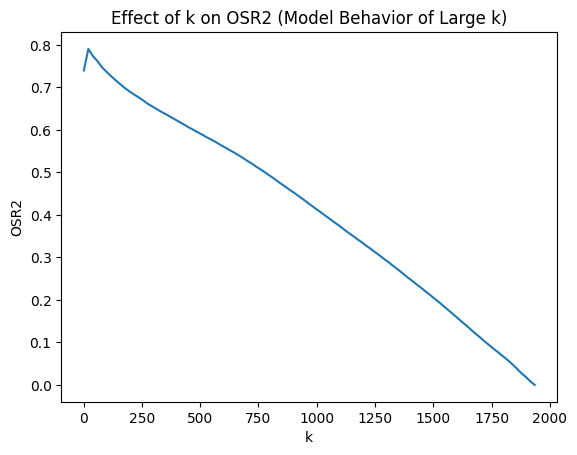

In [22]:
plt.plot(k_range, OSR2_list)
plt.xlabel('k')
plt.ylabel('OSR2')
plt.title("Effect of k on OSR2 (Model Behavior of Large k)")
plt.show()

As k increases, the model becomes more biased towards the training data, making it worse at predicting the test data since it's overfitting the training data.

12. **Parameter Tuning with GridSearchCV (20 points)**
    - Create a custom function called `Mean_Absolute_Price_Error()` that converts the predicted log prices back to the original prices and calculates the Mean Absolute Error (MAE) between the predicted prices and true prices. (5 points)
    - Use `GridSearchCV` to tune the `k` parameter of the KNN model, using the custom `Mean_Absolute_Price_Error()` function as the metric for model selection. Use `5-fold` cross validation. (5 points)
    - Plot the `MAE` for different values of `k`. (5 points)
    - Identify the `k` value that results in the smallest `Mean_Absolute_Price_Error`. (5 points)

In [31]:
def Mean_Absolute_Price_Error(y_test, y_predict):
    return np.mean(np.abs(np.exp(y_test) - np.exp(y_predict)))

In [35]:
param_grid = {"n_neighbors": np.arange(1, 250)}

In [36]:
gs = GridSearchCV(KNN, param_grid, cv=5, scoring=make_scorer(Mean_Absolute_Price_Error, greater_is_better=False))
gs.fit(X_train_scaled, y_train)

optimal_k = gs.best_params_["n_neighbors"]

GridSearchCV(cv=5,
             estimator=KNeighborsRegressor(metric='cityblock',
                                           n_neighbors=1935),
             param_grid={'n_neighbors': array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  8...
       183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195,
       196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208,
       209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221,
       222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234,
       235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247,
       248, 249])},
             scoring=make_scorer(Mean_Absolute_Price_Error, greater_is_better=False, response_method='predict'))

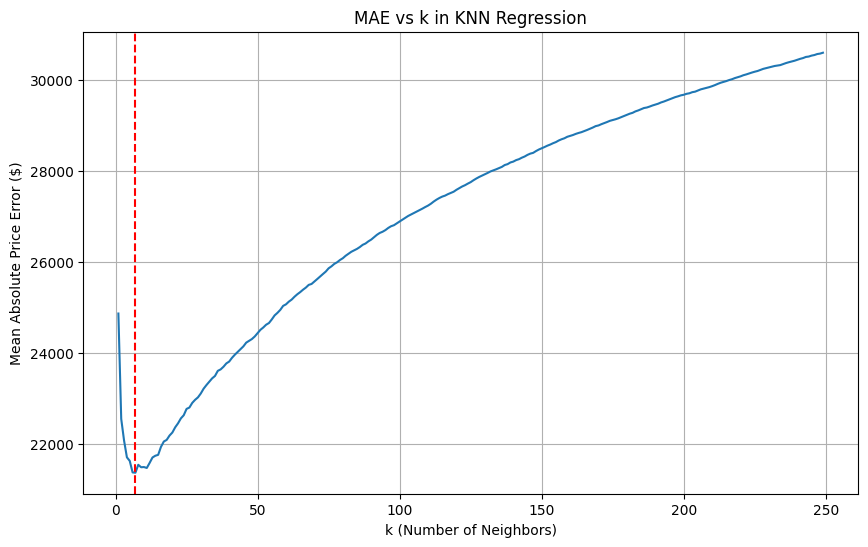

In [48]:
# Plot MAE vs k values
plt.figure(figsize=(10, 6))
plt.plot(param_grid["n_neighbors"], -gs.cv_results_["mean_test_score"], label="Mean Absolute Price Error")
plt.xlabel("k (Number of Neighbors)")

plt.axvline(x=optimal_k, color='red', linestyle='--')

plt.ylabel("Mean Absolute Price Error ($)")
plt.title("MAE vs k in KNN Regression")
plt.grid(True)
plt.show()

In [44]:
print(f"Best k value: {gs.best_params_["n_neighbors"]}")
print(f"Best MAE: {-gs.best_score_}")

Best k value: 7
Best MAE: 21371.824377847202


13. **Refit the Model (5 points)**
    - Refit the KNN model using the optimal `k` value from Problem 12. Print the out-of-sample performance (R2) of this final model.

In [45]:
KNN = KNeighborsRegressor(n_neighbors=optimal_k, metric="cityblock")
KNN.fit(X_train_scaled, y_train)
y_predict = KNN.predict(X_test_scaled)
print(f"OSR2: {OSR2(y_train, y_test, y_predict)}")

OSR2: 0.7988402219884047
